In [12]:
import os
from os.path import dirname
from pathlib import Path
from typing import List
import json
import math

import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

In [2]:
# Two sets of eight models of sizes 70M, 160M, 410M, 1B, 1.4B, 2.8B, 6.9B, and 12B. 
# For each size, there are two models: one trained on the Pile, 
# and one trained on the Pile after the dataset has been globally deduplicated.
# 143 evenly-spaced checkpoints from step1000 to step143000

In [3]:
# run_pythia_mmlu_custom.sh MODEL="EleutherAI/pythia-1b" GPU="4" TASK="mmlu_hs"

In [4]:
# get root directory
root = os.path.abspath('')
while root.split('/')[-1] != 'e2lm-cruise':
    root = dirname(root)

### Get results

In [18]:
# get results

#results_dir = 'examples/metadata_arch/custom_data_selection_results/results_pythia_1b_mmlu_easy/'
results_dir = 'examples/metadata_arch/custom_data_selection_results/results_pythia_1b_mmlu_easy_cloze/'
#results_dir = 'examples/metadata_arch/custom_data_selection_results/results_pythia_1b_mmlu_hard_cloze/'

In [19]:
results = []
for json_file in sorted(Path(root+'/'+results_dir).glob("**/*.json")):
    with json_file.open() as f:
        results.append(json.load(f))

# results for single task, single model, multiple checkpoints
model_name = results[0]['model_name_sanitized']
task = list(results[0]['group_subtasks'].keys())[0]

print(model_name, task)

EleutherAI__pythia-1b mmlu_easy_cloze


In [20]:
# collect data

steps = []
accuracies = []
error_bars = []


for checkpoint in results:
    
    # checkpoint
    step = checkpoint['configs'][task]['metadata']['revision']
    step = int(step.split('step')[-1])
    steps.append(step)
    
    # results
    values = checkpoint['results'][task]
    acc = values['acc,none']
    stderr = values['acc_stderr,none']
    accuracies.append(acc)
    error_bars.append(stderr)

#### Functions

In [21]:
# EMA
def smooth_tf(scalars: list[float], weight: float) -> list[float]:
    """
    EMA implementation according to
    https://github.com/tensorflow/tensorboard/blob/34877f15153e1a2087316b9952c931807a122aa7/tensorboard/components/vz_line_chart2/line-chart.ts#L699
    """
    last = 0
    smoothed = []
    num_acc = 0
    for next_val in scalars:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - math.pow(weight, num_acc)
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)

    return smoothed


def var(a):
    return sum((a - np.mean(a))**2) / len(a)


def normalize(a, min_a, max_a):
    return (a - min_a) / (max_a - min_a + 1e-20)


def autocorrelation(signal, lag=1):
    """Compute the autocorrelation at given lag."""
    n = len(signal)
    s1 = signal[lag:]
    s2 = signal[:n-lag]
    return np.corrcoef(s1, s2)[0, 1]


def spearmancorrelation(a):
    x, y = np.array(range(len(a))), np.array(a)
    x_rank = np.argsort(np.argsort(x))
    y_rank = np.argsort(np.argsort(y))
    n = len(x)
    d_squared_sum = np.sum((x_rank - y_rank)**2)
    rho = 1 - (6 * d_squared_sum) / (n * (n**2 - 1))
    return max(rho, 0)


def signal_quality_score(a):
    a_new = a
    sc = spearmancorrelation(a_new)
    ac = np.mean([np.abs(autocorrelation(a_new, i)) for i in range(1,len(a_new)//4)])
    return sc, ac, (sc + ac)/2

In [ ]:
# Use : https://github.com/tatami-galaxy/e2lm-cruise/blob/main/examples/starter_kit/5_Scoring.ipynb

### Plot

In [24]:
def var(a):
    return sum((a - np.mean(a))**2) / len(a)

def normalize(a, min_a, max_a):
    return (a - min_a) / (max_a - min_a + 1e-20)

def autocorrelation(signal, lag=1):
    """Compute the autocorrelation at given lag."""
    n = len(signal)
    s1 = signal[lag:]
    s2 = signal[:n-lag]
    return np.corrcoef(s1, s2)[0, 1]

def spearmancorrelation(a):
    x, y = np.array(range(len(a))), np.array(a)
    x_rank = np.argsort(np.argsort(x))
    y_rank = np.argsort(np.argsort(y))
    n = len(x)
    d_squared_sum = np.sum((x_rank - y_rank)**2)
    rho = 1 - (6 * d_squared_sum) / (n * (n**2 - 1))
    return max(rho, 0)

def signal_quality_score(a):
    a_new = a
    sc = spearmancorrelation(a_new)
    ac = np.mean([np.abs(autocorrelation(a_new, i)) for i in range(1,len(a_new)//4)])
    return sc, ac, (sc + ac)/2

In [25]:
signal_quality_score(np.array(accuracies))

(np.float64(0.8208082996815391),
 np.float64(0.5856274338790226),
 np.float64(0.7032178667802809))

/var/folders/mf/1drrrjnj46d15bvn70kgf3y40000gp/T/ipykernel_34305/3507742912.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


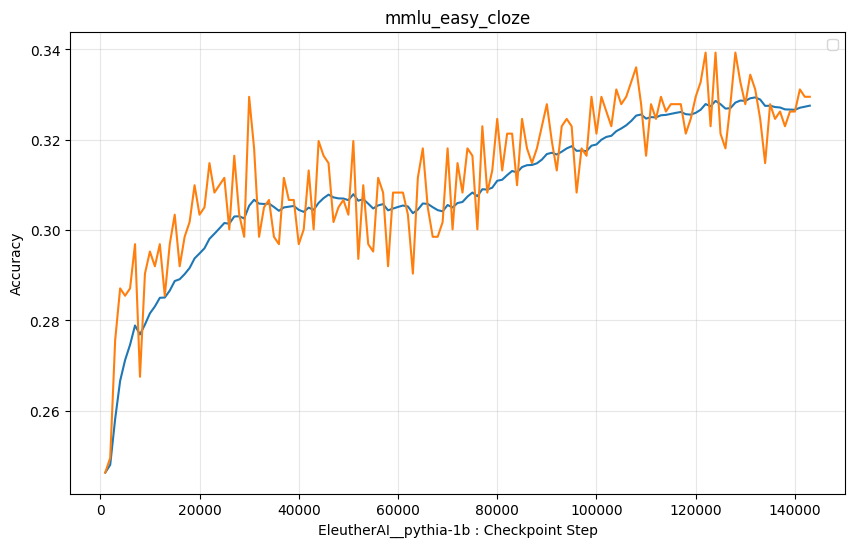

In [26]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Add labels and title
ax.set_xlabel('{} : Checkpoint Step'.format(model_name))
ax.set_ylabel('Accuracy')
ax.set_title(task)
ax.legend()
ax.grid(True, alpha=0.3)

ax.plot(steps, smooth_tf(accuracies, .9), label="acc smooth") 
ax.plot(steps, accuracies, label="acc")  
plt.show()